# Navier Stokes in a pipe flow (stationary 2D) with soft constraints (PINN & SPINN)

We solve the stationary Navier Stokes PDE:

$$
\begin{cases}
\nabla\cdot\mathbf{u}=0,\\
(\mathbf{u}\cdot\nabla)\mathbf{u} + \frac{1}{\rho}\nabla p - \theta \nabla^2\mathbf{u}=0.
\end{cases}
$$

This becomes in 2D, with $\mathbf{u}=\begin{pmatrix}u_x \\ u_y\end{pmatrix}$


$$
\begin{cases}
\frac{\partial}{\partial x} u_x + \frac{\partial}{\partial y} u_y = 0 \\
\begin{pmatrix}u_x\frac{\partial}{\partial x} u_x + u_y\frac{\partial}{\partial y} u_x \\
u_x\frac{\partial}{\partial x} u_y + u_y\frac{\partial}{\partial y} u_y  \end{pmatrix} +
\frac{1}{\rho} \begin{pmatrix} \frac{\partial}{\partial x} p \\ \frac{\partial}{\partial y} p \end{pmatrix}
- \theta
\begin{pmatrix}
\frac{\partial^2}{\partial x^2} u_x + \frac{\partial^2}{\partial y^2} u_x \\
\frac{\partial^2}{\partial x^2} u_y + \frac{\partial^2}{\partial y^2} u_y
\end{pmatrix} = 0\\
\end{cases}
$$


With the boundary condition:
$$
\begin{cases}
u(x, \frac{d}{2}) = -u(x, \frac{d}{2})=0, \forall x \text{ (boundary condition) }\\
p(x_{min}, y)=0 \text{ and } p(x_{max}, y)=0.1, \forall y \text{ (boundary condition) }
\end{cases}
$$

The domain is defined with $x\in[0,L]$ and $y\in[-R, R]$. __Note__ that because of the central symmetry with respect to the centerline of the tube, we only consider the $y$ axis which will represent the cross section

This notebook aims at reproducing the example of section 3.1 of [*Surrogate modeling for fluid flows based on physics-constrained deep learning without simulation data*, Sun et al. 2020](https://www.sciencedirect.com/science/article/pii/S004578251930622X).

__However, the constraints are set up differently, i.e., as a penalizing loss term rather than a (soft constraint) rather than a term multiplying the model output (hard constraint, as proposed in the article).__


To solve the PDE, we use both a classical PINN and a [Separable PINN](https://openreview.net/pdf?id=dEySGIcDnI) approach implemented in jinns.

## The PINN approach

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

Float64 and GPU settings

In [2]:
#import os; os.environ["JAX_ENABLE_X64"] = "TRUE" # comment/uncomment to  disable/enable float64 for JAX
#import os; os.environ["CUDA_VISIBLE_DEVICES"]="" # If uncommented then GPU is disable

Import our package

In [3]:
import jinns

2024-03-07 14:09:24.246013: W external/xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Import other dependencies

In [4]:
import jax
from jax import random, vmap
import jax.numpy as jnp
import equinox as eqx
from functools import partial
import matplotlib.pyplot as plt

key = random.PRNGKey(2)

Create the neural network architecture for the PINN with `equinox`. We have two Pinns for the velocity field `u` and for the pressure field `p`. The first one is vectorial (2D) the second one is scalar.

In [5]:
eqx_list = [
    [eqx.nn.Linear, 2, 50],
    [jax.nn.tanh],
    [eqx.nn.Linear, 50, 50],
    [jax.nn.tanh],
    [eqx.nn.Linear, 50, 50],
    [jax.nn.tanh],
    [eqx.nn.Linear, 50, 2],
]
key, subkey = random.split(key)
u = jinns.utils.create_PINN(subkey, eqx_list, "statio_PDE", 2)

eqx_list = [
    [eqx.nn.Linear, 2, 50],
    [jax.nn.tanh],
    [eqx.nn.Linear, 50, 50],
    [jax.nn.tanh],
    [eqx.nn.Linear, 50, 50],
    [jax.nn.tanh],
    [eqx.nn.Linear, 50, 1],
]
key, subkey = random.split(key)
p = jinns.utils.create_PINN(subkey, eqx_list, "statio_PDE", 2)

In [6]:
u_init_nn_params = u.init_params()
p_init_nn_params = p.init_params()

Create a DataGenerator object and set up some geometry. Following the [authors' implementation](https://github.com/Jianxun-Wang/LabelFree-DNN-Surrogate/blob/master/Tutorial/PipeFlow.ipynb), we set a pipe length $L=1$ and a pipe radius$R=0.05$. Following the authors, we also simplify the problem because of its geometry: the solution is symmetric with respect to the center of the pipe, at a given point $x\in[0, L]$. Therefore we only need one axis representing a pipe cross section and one axis representing the pipe length.

In [7]:
L = 1
R = 0.05

p_out = 0.
p_in = 0.1

In [8]:
n = 1000
nb = 500
omega_batch_size = 32
omega_border_batch_size = 32
dim = 2
xmin = 0
xmax = xmin + L
ymin = -R
ymax = ymin + 2 * R
method = "uniform"
key, subkey = random.split(key)
train_data = jinns.data.CubicMeshPDEStatio(
    subkey,
    n,
    nb,
    omega_batch_size,
    omega_border_batch_size,
    dim,
    (xmin, ymin),
    (xmax, ymax),
    method
)

__Note:__ that we choose a very simple data generator and no boundary condition despite the pipe-like geometry. Indeed, we choose to follow the author's hard coded boundary constraints. The neural network outputs are then multiplied with a factor which enforces the constraints. We impose the so-called _slip-condition_ on the borders, ie, the fluid as a null speed on the borders.

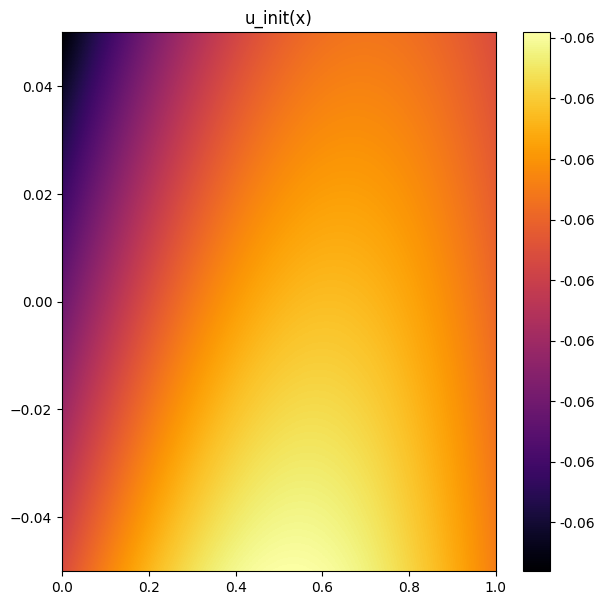

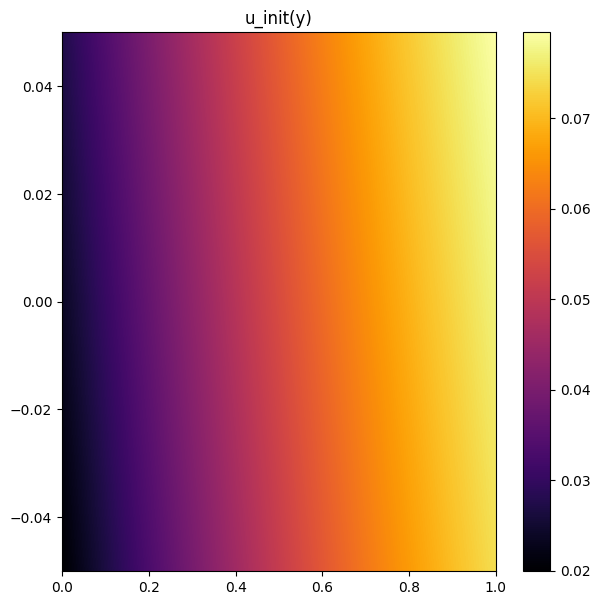

In [9]:
nx, ny = 1000, 1000
val_xy_data = [jnp.linspace(xmin, xmax, nx),
               jnp.linspace(ymin, ymax, ny)
              ]

u_xinit = lambda x: u(x, u_init_nn_params)[0]
jinns.data.plot2d(
    fun=u_xinit,
    xy_data=val_xy_data,
    title="u_init(x)"
)

u_yinit = lambda x: u(x, u_init_nn_params)[1]
jinns.data.plot2d(
    fun=u_yinit,
    xy_data=val_xy_data,
    title="u_init(y)"
)

We also impose the pressure inlet and outlet condition

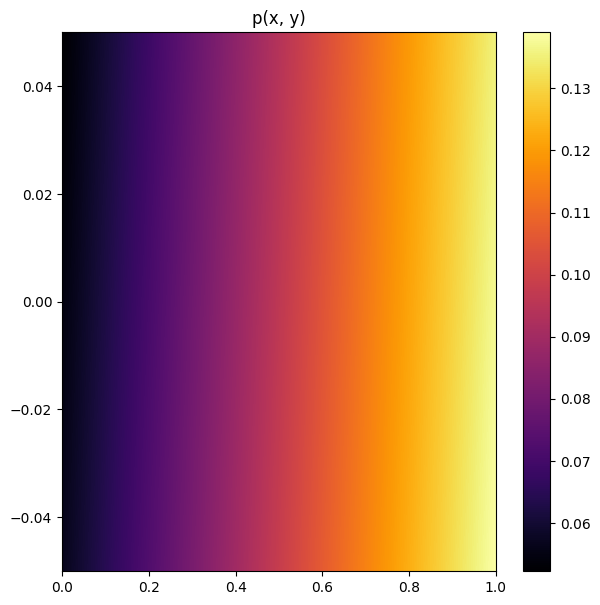

In [10]:
jinns.data.plot2d(
    fun = lambda x: p(x, p_init_nn_params),
    xy_data=val_xy_data,
    title = "p(x, y)"
)

## Model parameters

Here we set the density $\rho=1$ and we simplify the problem with respect to the article: $\theta$ is the viscosity parameter which we fix and feed as input to the PINN as done in the article; $\theta=0.00061$

In [11]:
rho = 1.
nu = 0.00061

Delta_p = 0.1
d = 2 * R

A set of parameters as required by the losses' `evaluate`. Here we adapt to the particular dynamic loss which requires the keys `u` and `p`.

In [12]:
# initiate parameters dictionary
init_params = {}
init_params['nn_params'] = {
    "u": u_init_nn_params,
    "p": p_init_nn_params
}
init_params["eq_params"] = {"rho":rho, "nu":nu}

## Analytical solution
In this case, the analytical solution is known:
$$
u_a = \frac{\Delta p}{2\theta\rho L}(\frac{d^2}{4} - y^2)
$$

Text(0.5, 1.0, 'True solution along a cross section')

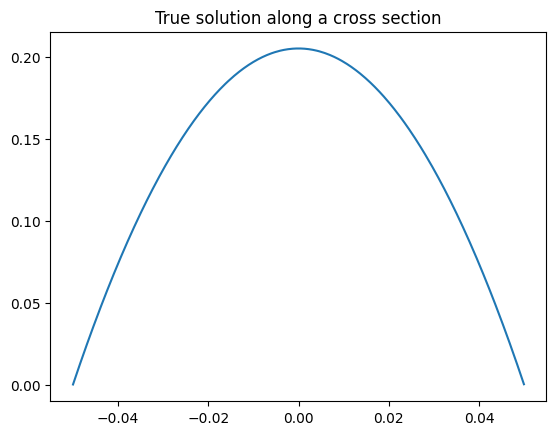

In [13]:
def u_true(x):
    return Delta_p / (2 * nu * rho * L) * ((d / 2) ** 2 - x ** 2)

plt.plot(train_data.omega[:, 1].sort(axis=0), vmap(u_true, (0), 0)(train_data.omega[:, 1].sort(axis=0)))
plt.title(r"True solution along a cross section")

## Loss construction

First create the boundary functions that we will use for `p` and `u`. These functions will be vmapped (internally, just like the PINNs). The `omega_boundary_fun` can be:

- a simple function that will be applied to all the facets. In this case it goes with a `omega_boundary_condition` that is just a string `"neumann"` or `"dirichlet"`.

- a dict of functions for the different functions to apply to each facet. Note that in 2D, the facets must be in the order `"xmin", "xmax", "ymin", "ymax"`. In this case, it goes with `omega_boundary_condition` which is a dict with the same key order and values being either `"neumann"` or `"dirichlet"`. Note that we can have no boundary condition given a facet, in this case the value is `None` in both dictionaries.

In [14]:
p_omega_boundary_fun = {
    "xmin": lambda x: p_in,
    "xmax": lambda x: p_out,
    "ymin": None,
    "ymax": None
}
p_omega_boundary_condition = {
    "xmin": "dirichlet",
    "xmax": "dirichlet",
    "ymin": None,
    "ymax": None
}

u_omega_boundary_fun = {
    "xmin": None,
    "xmax": None,
    "ymin": lambda x: jnp.array([0.0, 0.0]),
    "ymax": lambda x: jnp.array([0.0, 0.0]),
}
u_omega_boundary_condition = {
    "xmin": None,
    "xmax": None,
    "ymin": "dirichlet",
    "ymax": "dirichlet",
}

In [15]:
mc_loss = jinns.loss.MassConservation2DStatio(nn_key='u')
ns_loss = jinns.loss.NavierStokes2DStatio(u_key='u', p_key='p')

In [16]:
loss_weights = {"dyn_loss":1., "boundary_loss":1.}

loss = jinns.loss.SystemLossPDE(
    u_dict={'u':u, 'p':p},
    loss_weights=loss_weights,
    dynamic_loss_dict={'mass_conservation':mc_loss, 'navier_stokes':ns_loss},
    nn_type_dict={'u':'nn_statio', 'p':'nn_statio'},
    omega_boundary_fun_dict={'u': u_omega_boundary_fun, 'p': p_omega_boundary_fun},
    omega_boundary_condition_dict={'u': u_omega_boundary_condition,'p': p_omega_boundary_condition}
)

In [17]:
# Testing the loss function
losses_and_grad = jax.value_and_grad(loss.evaluate, 0, has_aux=True)
key, subkey = random.split(key)
losses, grads = losses_and_grad(
    init_params,
    batch = train_data.get_batch()
)


l_tot, dict_losses = losses
print(f"total loss: {l_tot:.2f}")
print(f"Individual losses: { {key: f'{val:.2f}' for key, val in dict_losses.items()} }")

total loss: 0.05
Individual losses: {'boundary_loss': '0.03', 'dyn_loss': '0.01', 'initial_condition': '0.00', 'norm_loss': '0.00', 'observations': '0.00', 'sobolev': '0.00'}


## Learning the neural network parameters
The learning process here consider known equation parameters `eq_params`. We thus only update `nn_params`

In [18]:
params = init_params

In [19]:
# Optimizer
import optax

tx = optax.adamw(learning_rate=1e-3)

In [20]:
n_iter = int(20000)

In [21]:
key, subkey = random.split(key, 2)
params, total_loss_list, loss_by_term_dict, data, loss, _, _ , _, _ = jinns.solve(
    init_params=params,
    data=train_data,
    optimizer=tx,
    loss=loss,
    n_iter=n_iter
)

Iteration 0: loss value = 0.0461442694067955


  0%|          | 0/20000 [00:00<?, ?it/s]

Iteration 1000: loss value = 0.003348573576658964
Iteration 2000: loss value = 0.0033471102360635996
Iteration 3000: loss value = 0.003476756624877453
Iteration 4000: loss value = 0.0032741983886808157
Iteration 5000: loss value = 0.002757389098405838
Iteration 6000: loss value = 0.00019392379908822477
Iteration 7000: loss value = 0.0001506081025581807
Iteration 8000: loss value = 0.00013996617053635418
Iteration 9000: loss value = 8.281175541924313e-05
Iteration 10000: loss value = 0.00010192270565312356
Iteration 11000: loss value = 5.622196476906538e-05
Iteration 12000: loss value = 4.428249303600751e-05
Iteration 13000: loss value = 1.5954621630953625e-05
Iteration 14000: loss value = 1.1782056390075013e-05
Iteration 15000: loss value = 3.919204755220562e-05
Iteration 16000: loss value = 5.227998371992726e-06
Iteration 17000: loss value = 2.4617953386041336e-05
Iteration 18000: loss value = 5.689690624421928e-06
Iteration 19000: loss value = 1.0344105248805135e-05
Iteration 20000: 

## Results

Plot the loss values

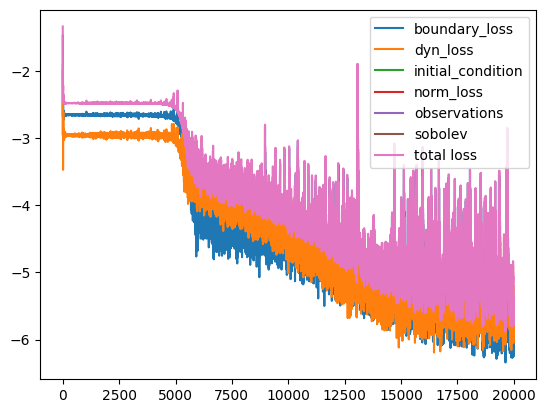

In [22]:
for loss_name, loss_values in loss_by_term_dict.items():
    plt.plot(jnp.log10(loss_values), label=loss_name)
plt.plot(jnp.log10(total_loss_list), label="total loss")
plt.legend()
plt.show();

Plot the ODE solutions learned by the PINN

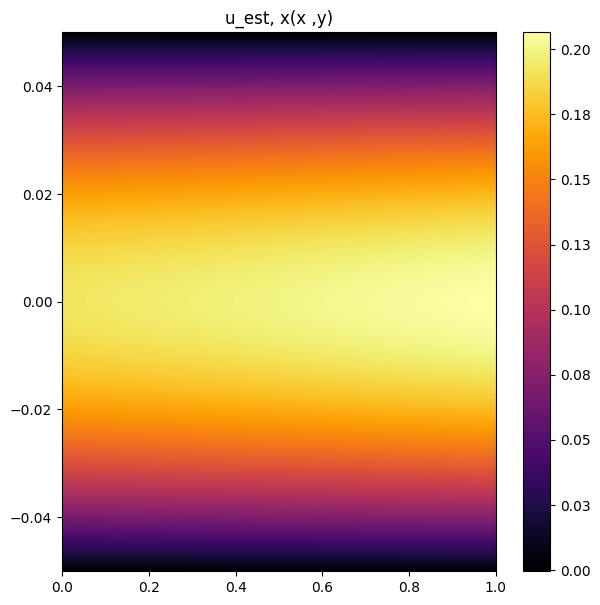

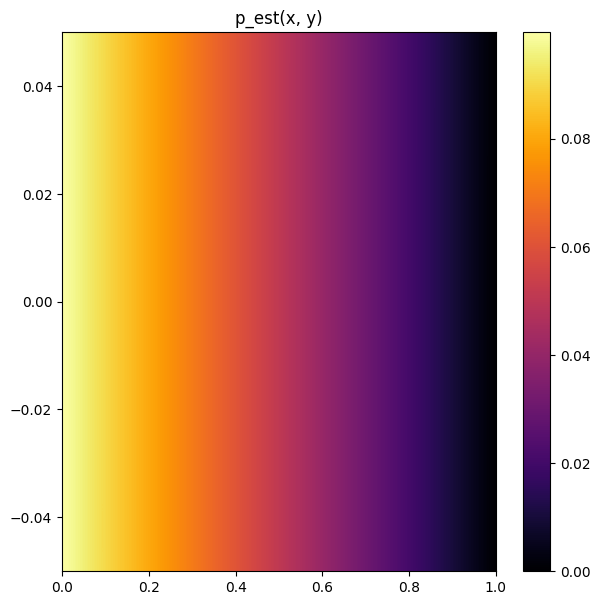

In [23]:
jinns.data.plot2d(
    fun = lambda x: u(x, params['nn_params']['u'])[0],
    xy_data = val_xy_data,
    title="u_est, x(x ,y)"
)

jinns.data.plot2d(
    fun = lambda x: p(x, params['nn_params']['p']),
    xy_data = val_xy_data,
    title="p_est(x, y)"
)

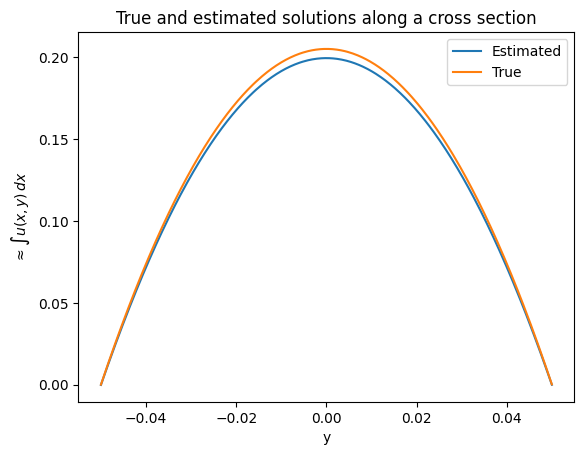

In [24]:
v_u_est_y = vmap(
    # compute average over array x with y_j fixed.
    lambda x, y_j: vmap(lambda z: u(jnp.stack([z, y_j], axis=-1), params["nn_params"]["u"])[0],
                        0, 0)(x).mean(),
    (None, 0),
    0)


plt.plot(train_data.omega[:, 1].sort(axis=0),
         v_u_est_y(train_data.omega[:, 0].sort(axis=0),
                   train_data.omega[:, 1].sort(axis=0)),
         label="Estimated")
plt.plot(train_data.omega[:, 1].sort(axis=0),
         vmap(u_true, (0), 0)(train_data.omega[:, 1].sort(axis=0)),
         label="True")
plt.xlabel("y")
plt.ylabel(r"$\approx \int u(x, y) \, dx$")
plt.legend()
plt.title(r"True and estimated solutions along a cross section")
plt.show()

## The SPINN approach

In [25]:
d_ = 2
r = 32
m = 2
eqx_list = [
    [eqx.nn.Linear, 1, 25],
    [jax.nn.tanh],
    [eqx.nn.Linear, 25, 25],
    [jax.nn.tanh],
    [eqx.nn.Linear, 25, 25],
    [jax.nn.tanh],
    [eqx.nn.Linear, 25, r * m]
]
key, subkey = random.split(key)
u = jinns.utils.create_SPINN(subkey, d_, r, eqx_list, "statio_PDE", m)

d_ = 2
r = 32
eqx_list = [
    [eqx.nn.Linear, 1, 25],
    [jax.nn.tanh],
    [eqx.nn.Linear, 25, 25],
    [jax.nn.tanh],
    [eqx.nn.Linear, 25, 25],
    [jax.nn.tanh],
    [eqx.nn.Linear, 25, r]
]
key, subkey = random.split(key)
p = jinns.utils.create_SPINN(subkey, d_, r, eqx_list, "statio_PDE")

In [26]:
u_init_nn_params = u.init_params()
p_init_nn_params = p.init_params()

Note the `cartesian_product=False` in the cell below, which tells the `train_data_spinn` DataGenerator not to output cartesian product of space and time collocation points. It is because we use a separable PINN (SPINN) which already does similar operations internally (more precisely, outer products of each axis-dimension). 

In [27]:
n = 500
nb = 500
omega_batch_size = 32
omega_border_batch_size = 32
dim = 2
xmin = 0
xmax = xmin + L
ymin = -R
ymax = ymin + 2 * R

method = "uniform"
key, subkey = random.split(key)
train_data = jinns.data.CubicMeshPDEStatio(
    subkey,
    n,
    nb,
    omega_batch_size,
    omega_border_batch_size,
    dim,
    (xmin, ymin),
    (xmax, ymax),
    method,
    cartesian_product=False
)

In [28]:
# initiate parameters dictionary
init_params = {}
init_params['nn_params'] = {
    "u": u_init_nn_params,
    "p": p_init_nn_params
}
init_params["eq_params"] = {"rho":rho, "nu":nu}

In [29]:
p_omega_boundary_fun = {
    "xmin": lambda x: p_in,
    "xmax": lambda x: p_out,
    "ymin": None,
    "ymax": None
}
p_omega_boundary_condition = {
    "xmin": "dirichlet",
    "xmax": "dirichlet",
    "ymin": None,
    "ymax": None
}

u_omega_boundary_fun = {
    "xmin": None,
    "xmax": None,
    "ymin": lambda x: jnp.array([0.0, 0.0]),
    "ymax": lambda x: jnp.array([0.0, 0.0]),
}
u_omega_boundary_condition = {
    "xmin": None,
    "xmax": None,
    "ymin": "dirichlet",
    "ymax": "dirichlet",
}
mc_loss = jinns.loss.MassConservation2DStatio(nn_key='u')
ns_loss = jinns.loss.NavierStokes2DStatio(u_key='u', p_key='p')
loss_weights = {"dyn_loss":1., "boundary_loss":1.}

loss = jinns.loss.SystemLossPDE(
    u_dict={'u':u, 'p':p},
    loss_weights=loss_weights,
    dynamic_loss_dict={'mass_conservation':mc_loss, 'navier_stokes':ns_loss},
    nn_type_dict={'u':'nn_statio', 'p':'nn_statio'},
    omega_boundary_fun_dict={'u': u_omega_boundary_fun, 'p': p_omega_boundary_fun},
    omega_boundary_condition_dict={'u': u_omega_boundary_condition,'p': p_omega_boundary_condition}
)

In [30]:
params = init_params

In [31]:
# Optimizer
import optax
tx = optax.adamw(learning_rate=1e-3)
n_iter = int(10000)
key, subkey = random.split(key, 2)
params, total_loss_list, loss_by_term_dict, data, loss, _, _ , _, _ = jinns.solve(
    init_params=params,
    data=train_data,
    optimizer=tx,
    loss=loss,
    n_iter=n_iter
)

Iteration 0: loss value = 0.022023456171154976


  0%|          | 0/10000 [00:00<?, ?it/s]

Iteration 1000: loss value = 0.0033434461802244186
Iteration 2000: loss value = 0.0033521894365549088
Iteration 3000: loss value = 0.0032524224370718002
Iteration 4000: loss value = 0.0028965906240046024
Iteration 5000: loss value = 0.002021872904151678
Iteration 6000: loss value = 0.0002776659093797207
Iteration 7000: loss value = 0.00015170074766501784
Iteration 8000: loss value = 0.0001447936665499583
Iteration 9000: loss value = 2.987616062455345e-05
Iteration 10000: loss value = 5.755207530455664e-05


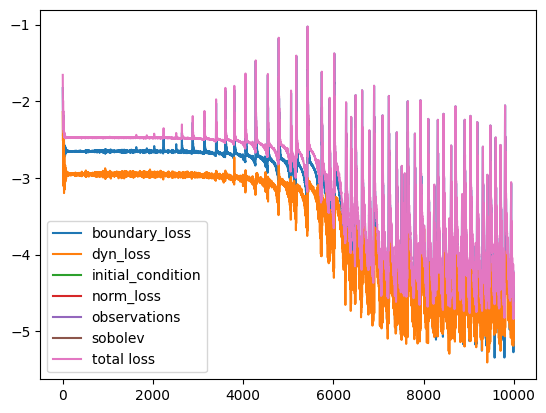

In [32]:
for loss_name, loss_values in loss_by_term_dict.items():
    plt.plot(jnp.log10(loss_values), label=loss_name)
plt.plot(jnp.log10(total_loss_list), label="total loss")
plt.legend()
plt.show();

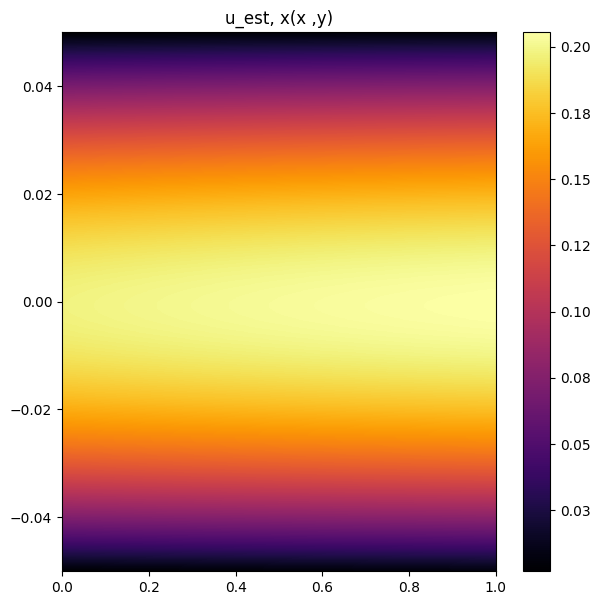

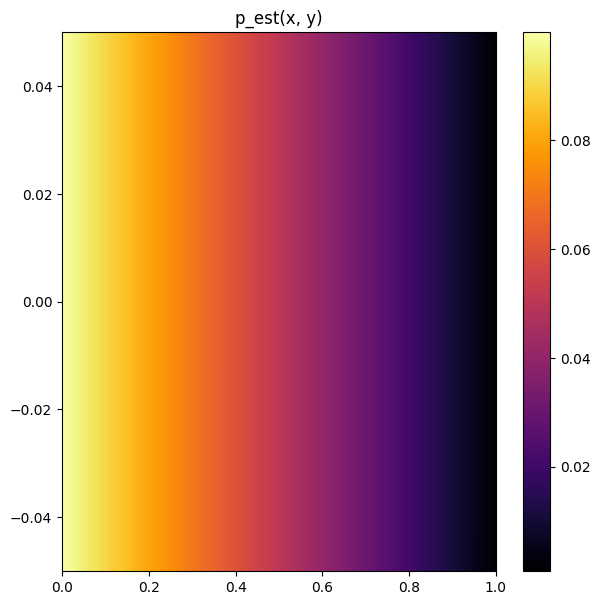

In [33]:
jinns.data.plot2d(
    fun = lambda x: u(x, params['nn_params']['u'])[..., 0:1],
    xy_data = val_xy_data,
    title="u_est, x(x ,y)",
    spinn=True
)

jinns.data.plot2d(
    fun = lambda x: p(x, params['nn_params']['p']),
    xy_data = val_xy_data,
    title="p_est(x, y)",
    spinn=True
)

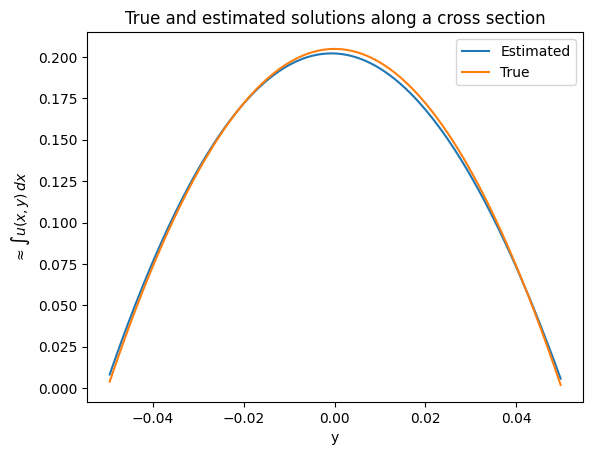

In [34]:
plt.plot(train_data.omega[:, 1].sort(axis=0),
         jnp.mean(u(jnp.stack([train_data.omega[:, 0].sort(axis=0),
                   train_data.omega[:, 1].sort(axis=0)], axis=-1), params["nn_params"]["u"])[..., 0], axis=0),
         label="Estimated")
plt.plot(train_data.omega[:, 1].sort(axis=0),
         vmap(u_true, (0), 0)(train_data.omega[:, 1].sort(axis=0)),
         label="True")
plt.xlabel("y")
plt.ylabel(r"$\approx \int u(x, y) \, dx$")
plt.legend()
plt.title(r"True and estimated solutions along a cross section")
plt.show()

## Conclusion

We solved this simple Navier-Stokes problem with both SPINNs and PINNs, getting the same results in a similar amount of time:

- PINNs: 20000/20000 [00:32<00:00, 614.97it/s]
- SPINNs: 10000/10000 [00:37<00:00, 268.19it/s]

(Times obtained on a Nvidia T600 Laptop GPU)

Higher dimensional problems should be investigated to really grasp to potential of SPINNs.